In [1]:
import math
import functools
from typing import Dict, Tuple

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex
    
try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire

from qdax import environments
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.tasks.brax_envs import scoring_function_brax_envs
from qdax.types import EnvState, Params, RNGKey
from qdax.core.containers.mapelites_repertoire import (
    MapElitesRepertoire,
    compute_cvt_centroids,
)

from qdax.core.emitters.cma_me_policies import (
    PolicyCMAOptimizingEmitter,
    PolicyCMAImprovementEmitter,
    PolicyCMARndEmitter,
    PolicyCMAPoolEmitter,
) 
from typing import Dict

/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please u

In [2]:
batch_size = 1000
env_name = "pointmaze"
episode_length = 100
num_iterations = 1000
seed = 42
policy_hidden_layer_sizes = (64, 64)
num_init_cvt_samples = 1000
num_centroids = 1000
min_bd = -1.0
max_bd = 1.0
emitter_type = "imp" #@param["opt", "imp", "rnd"]
pool_size = 10 #@param {type:"integer"}
sigma_g = .1

es_type = "Sep_CMA_ES"
# es_type = "CMA_ES"

In [3]:
from evosax import Strategies
assert es_type in Strategies, f"{es_type} is not one of {Strategies.keys()}"

## Defines the scoring function

In [4]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

# Define the fonction to play a step with the policy in the environment
def play_step_fn(
    env_state: EnvState,
    policy_params: Params,
    random_key: RNGKey,
) -> Tuple[EnvState, Params, RNGKey, QDTransition]:
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)

    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

# Prepare the scoring function
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function_brax_envs,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
def metrics_fn(repertoire: MapElitesRepertoire) -> Dict:

    # Get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    qd_score = jnp.sum(repertoire.fitnesses, where=~grid_empty)
    # Add offset for positive qd_score
    qd_score += reward_offset * episode_length * jnp.sum(1.0 - grid_empty)
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(repertoire.fitnesses)

    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)


## Emitters

In [5]:
es_params = {
    "sigma_init": sigma_g,
}

emitter_kwargs = {
    "batch_size": batch_size,
    "centroids": centroids,
    "es_params": es_params,
    "min_count": 1,
    "max_count": None,
    "es_type": es_type,
}


if emitter_type == "opt":
    emitter = PolicyCMAOptimizingEmitter(**emitter_kwargs)
elif emitter_type == "imp":
    emitter = PolicyCMAImprovementEmitter(**emitter_kwargs)
elif emitter_type == "rnd":
    emitter = PolicyCMARndEmitter(**emitter_kwargs)
else:
    raise Exception("Invalid emitter type")

emitter = PolicyCMAPoolEmitter(
    num_states=pool_size,
    emitter=emitter
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_fn,
)

emitter

## Init repertoire and emitter state

In [6]:
# Compute initial repertoire
with jax.disable_jit(): #Issues with list comprehension in QDax reshaper
    repertoire, emitter_state, random_key = map_elites.init(
        init_variables, centroids, random_key
    )

/home/paul/Dev/QDax/qdax/core/map_elites.py:80: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


## Run optimization / Illumination process

In [9]:
%%time

(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    map_elites.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

CPU times: user 2min 37s, sys: 2.81 s, total: 2min 40s
Wall time: 2min 39s


In [10]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 1000000: 99.9000015258789
max_fitness after 1000000: -28.410106658935547
qd_score after 1000000: 142933.4375


## Plot results

/home/paul/.local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


Save figure in:  ./plots/pointmaze/Sep_CMA_ES_ME_imp.png


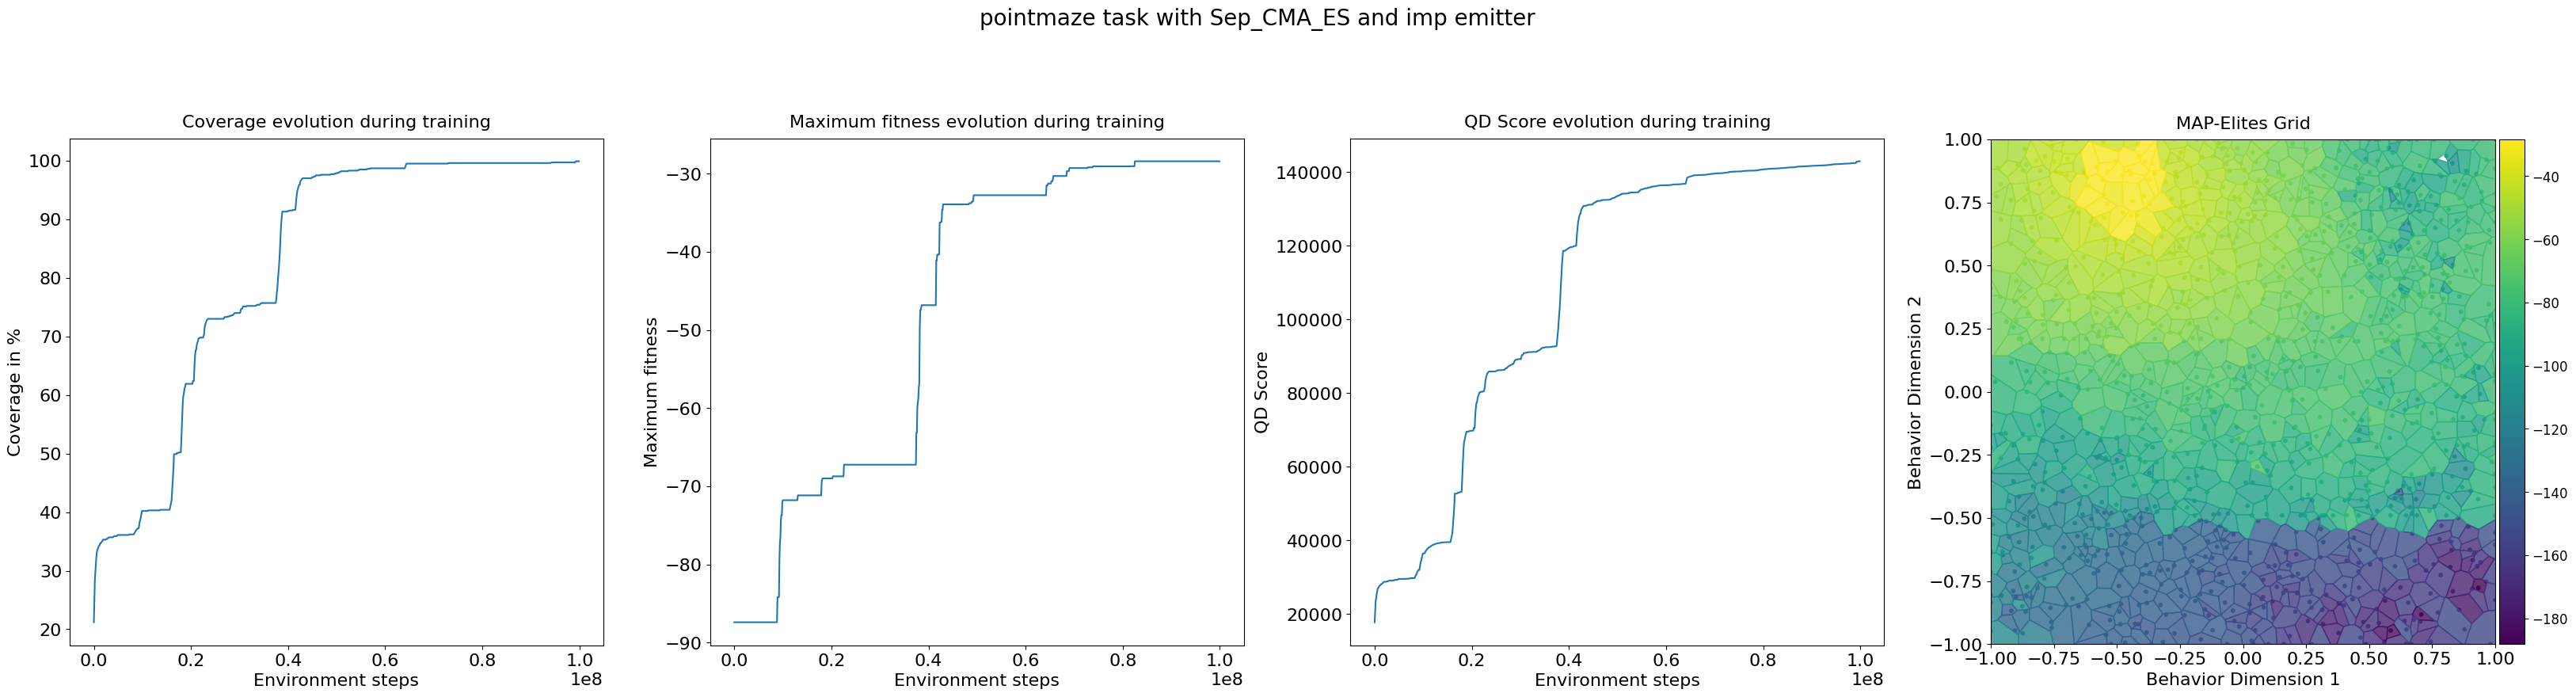

In [11]:
env_steps = jnp.arange(num_iterations) * batch_size * episode_length

from qdax.utils.plotting import plot_map_elites_results
import matplotlib

%matplotlib inline
fig, axes = plot_map_elites_results(
    env_steps=env_steps,
    metrics=metrics,
    repertoire=repertoire,
    min_bd=min_bd,
    max_bd=max_bd,
)

# main title
plt.suptitle(f"{env_name} task with {es_type} and {emitter_type} emitter", fontsize=20)

# udpate this variable to save your results locally
savefig = True
if savefig:
    figname = f"./plots/{env_name}/{es_type}_ME_"  + emitter_type + ".png"
    # create folder if it does not exist
    import os
    os.makedirs(os.path.dirname(figname), exist_ok=True)
    print("Save figure in: ", figname)
    plt.savefig(figname)